## TECHNICAL TEST  - METRODATA

PT ABC adalah perusahaan yang bergerak di bidang produksi roti. Hasil produksi didistibusikan ke berbagai outlet atau store rekanan. Perusahaan tersebut kerap mengalami masalah karena banyak roti yang tidak terjual, sehingga produk retur karena kedalursa cukup banyak. Anda sebagai Data Scientist diminta untuk memberikan solusi berbasis machine learning yang dapat memberikan rekomendasi berupa jumlah unit roti atau order quantity yang sebaiknya dititipkan ke setiap outlet. Gunakan dataset terlampir dan lakukan demand forecasting per store secara harian. Point yg dinilai berupa presentasi hasil yang memuat:
1.	Hasil forecast untuk demand selama 7 hari dan 30 hari kedepan
2.	Penjelasan workflow machine learning yang dibuat
3.	Gunakan 2 jenis algoritma yaitu Time series dan Regresi dan masing-masing algoritma gunakan minimal 2 alternatif model
4.	Summary model performance 

In [2]:
# Import common packages
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import time
import lightgbm as lgb
import xgboost as xgb
from fastai.imports import *
from fastai.structured import *
from fbprophet import Prophet

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

color = sns.color_palette()
sns.set_style('darkgrid')

ModuleNotFoundError: No module named 'lightgbm'

In [2]:
# Read excel dataset
df = pd.read_excel("../raw/dataset.xls")

In [3]:
df.head()

,date,order_qty,product_id,store
0,20180626,0.416667,A1,7079
1,20180626,0.416667,A1,7088
2,20180609,0.208333,B2,7081
3,20180609,0.041667,B2,7081
4,20180609,0.041667,B2,7081


In [4]:
# Check missing values
df.isnull().sum()

date          0
order_qty     0
product_id    0
store         0
dtype: int64

In [5]:
# Check the type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17121 entries, 0 to 17120
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        17121 non-null  int64  
 1   order_qty   17121 non-null  float64
 2   product_id  17121 non-null  object 
 3   store       17121 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 535.2+ KB


In [6]:
# Typcasting date from "int" into "str" and change format into datetime
df['date'] = df['date'].astype('string')
df['date'] = pd.to_datetime(df['date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17121 entries, 0 to 17120
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        17121 non-null  datetime64[ns]
 1   order_qty   17121 non-null  float64       
 2   product_id  17121 non-null  object        
 3   store       17121 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 535.2+ KB


In [7]:
# Set index from date column
df.set_index('date', inplace=True)

In [8]:
df = df.sort_index()

In [9]:
# Typcasting store from "int" into "str"
df['store'] = df['store'].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17121 entries, 2016-08-01 to 2018-12-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_qty   17121 non-null  float64
 1   product_id  17121 non-null  object 
 2   store       17121 non-null  string 
dtypes: float64(1), object(1), string(1)
memory usage: 535.0+ KB


In [10]:
df['year'] =  df.index.year
df['month'] =  df.index.month
df['day'] =  df.index.day
df['weekday'] =  df.index.weekday

df.head()

,order_qty,product_id,store,year,month,day,weekday
date,,,,,,,
2016-08-01,0.708333,E5,7079,2016,8,1,0
2016-08-01,0.791667,E5,7088,2016,8,1,0
2016-08-01,12.500000,E5,7079,2016,8,1,0
2016-08-01,1.041667,E5,7088,2016,8,1,0
2016-08-01,0.416667,E5,7088,2016,8,1,0


In [11]:
df.index.duplicated().sum()

16451

In [12]:
df.describe()

,order_qty,year,month,day,weekday
count,17121.000000,17121.000000,17121.000000,17121.000000,17121.000000
mean,0.669138,2017.184569,6.749781,10.202558,2.188248
std,1.446521,0.673634,3.471059,8.682535,1.674895
min,0.000000,2016.000000,1.000000,1.000000,0.000000
25%,0.083333,2017.000000,4.000000,2.000000,1.000000
50%,0.208333,2017.000000,7.000000,8.000000,2.000000
75%,0.625000,2018.000000,10.000000,17.000000,3.000000
max,25.000000,2018.000000,12.000000,31.000000,6.000000


In [13]:
df['product_id'].unique()

array(['E5', 'B2', 'G7', 'A1', 'C3', 'D4', 'F6'], dtype=object)

In [14]:
df['store'].unique()

<StringArray>
['7079', '7088', '7084', '7081', '7082']
Length: 5, dtype: string

In [15]:
min_date = df.index.min()
max_date = df.index.max()
# diff_date = max_date - max_date

print(f"Tanggal mulai : {min_date}")
print(f"Tanggal akhir : {max_date}")
# print(f"Rentang waktu : {diff_date}")

Tanggal mulai : 2016-08-01 00:00:00
Tanggal akhir : 2018-12-01 00:00:00


In [30]:
# Split dataframe for each product_id & store
g = globals()
list_dataframe = []

for product in df['product_id'].unique():
    for store in df[df['product_id'] == product]['store'].unique():
        # Create a DataFrame for each combination
        df_name = f'df_{product}_{store}'
        
        g[f'df_{product}_{store}'] = df[(df['product_id'] == product) & (df['store'] == store)].sort_index()
        g[f'df_{product}_{store}']['order_qty'] = g[f'df_{product}_{store}'].groupby([g[f'df_{product}_{store}'].index])['order_qty'].sum()
        g[f'df_{product}_{store}'].drop_duplicates(inplace=True)

        list_dataframe.append(df_name)
        print(f'Total rows in df_{product}_{store} :', len(g[f'df_{product}_{store}']))

Total rows in df_E5_7079 : 440
Total rows in df_E5_7088 : 299
Total rows in df_E5_7084 : 6
Total rows in df_E5_7081 : 34
Total rows in df_B2_7081 : 422
Total rows in df_G7_7082 : 60
Total rows in df_A1_7088 : 70
Total rows in df_A1_7079 : 131
Total rows in df_A1_7081 : 15
Total rows in df_C3_7082 : 30
Total rows in df_D4_7081 : 146
Total rows in df_F6_7079 : 54
Total rows in df_F6_7088 : 59


In [35]:
stacked_df = pd.concat([globals()[df_name] for df_name in list_dataframe], axis=0)
stacked_df

,order_qty,product_id,store,year,month,day,weekday
date,,,,,,,
2016-08-01,128.916667,E5,7079,2016,8,1,0
2016-08-02,0.583333,E5,7079,2016,8,2,1
2016-08-03,2.166667,E5,7079,2016,8,3,2
2016-08-04,0.333333,E5,7079,2016,8,4,3
2016-08-05,2.500000,E5,7079,2016,8,5,4
...,...,...,...,...,...,...,...
2018-11-13,1.875000,F6,7088,2018,11,13,1
2018-11-16,1.041667,F6,7088,2018,11,16,4
2018-11-19,0.291667,F6,7088,2018,11,19,0


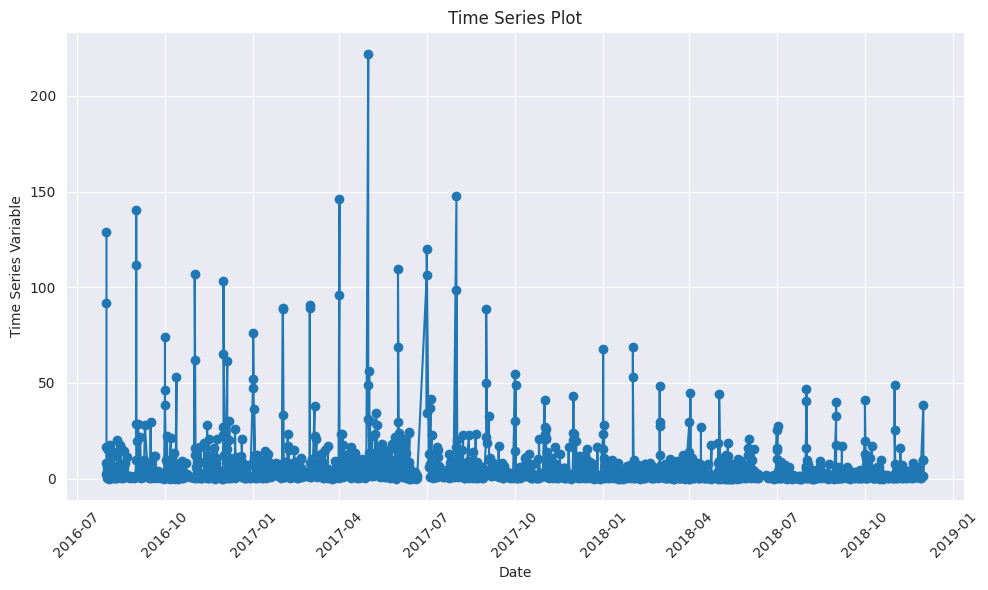

In [41]:
# Plot for "Daily" order
# Example DataFrame creation with datetime index
df_daily_plot = stacked_df.sort_index()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(df_daily_plot.index, df_daily_plot['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


In [42]:
df_daily_plot

,order_qty,product_id,store,year,month,day,weekday
date,,,,,,,
2016-08-01,128.916667,E5,7079,2016,8,1,0
2016-08-01,16.541667,E5,7084,2016,8,1,0
2016-08-01,92.000000,B2,7081,2016,8,1,0
2016-08-01,8.000000,G7,7082,2016,8,1,0
2016-08-01,2.416667,E5,7088,2016,8,1,0
...,...,...,...,...,...,...,...
2018-11-28,0.416667,F6,7079,2018,11,28,2
2018-12-01,38.416667,D4,7081,2018,12,1,5
2018-12-01,9.750000,C3,7082,2018,12,1,5


In [43]:
stacked_df_w = stacked_df.resample('w').sum()

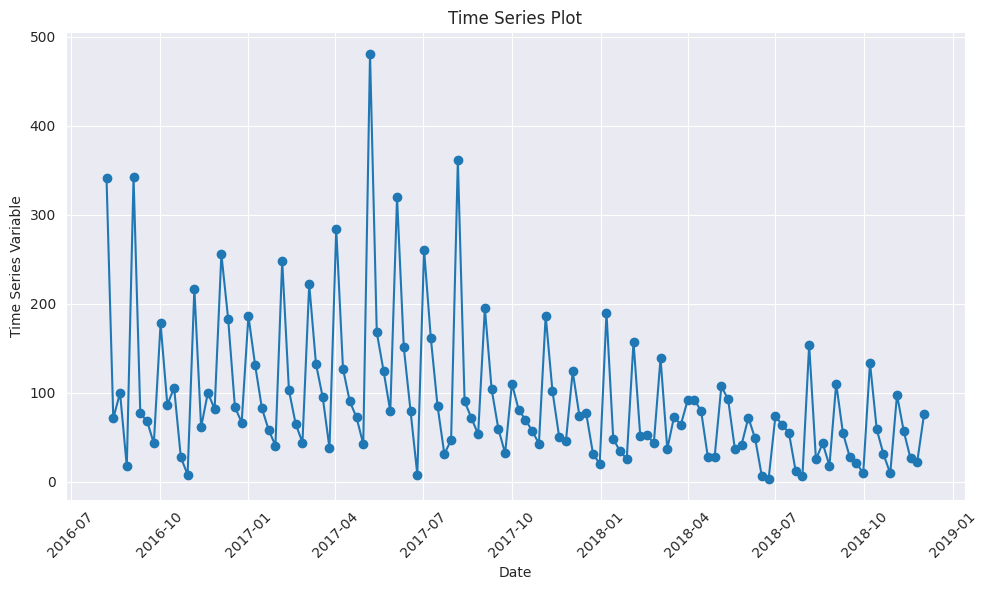

In [44]:
# Plot for "Weekly" order
# Example DataFrame creation with datetime index
# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(stacked_df_w.index, stacked_df_w['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


In [96]:
stacked_df_m = stacked_df.resample('m').sum()

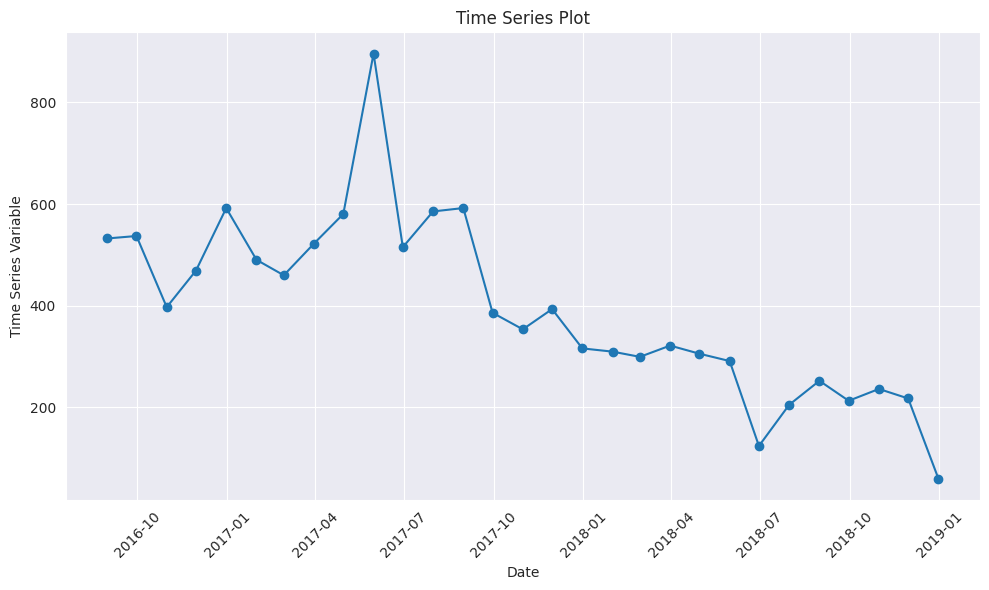

In [97]:
# Plot for "Monthly" order
# Example DataFrame creation with datetime index
# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(stacked_df_m.index, stacked_df_m['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


In [ ]:
# Split dataframe for each product_id
g = globals()

for product in df['product_id'].unique():
    for store in df[df['product_id'] == product]['store'].unique():
        # Create a DataFrame for each combination
        g[f'df_{product}_{store}'] = g[f'df_{product}_{store}'].drop_duplicates(inplace=True)
        print(f'Total rows in df_{product}_{store} :', len(g[f'df_{product}_{store}']))

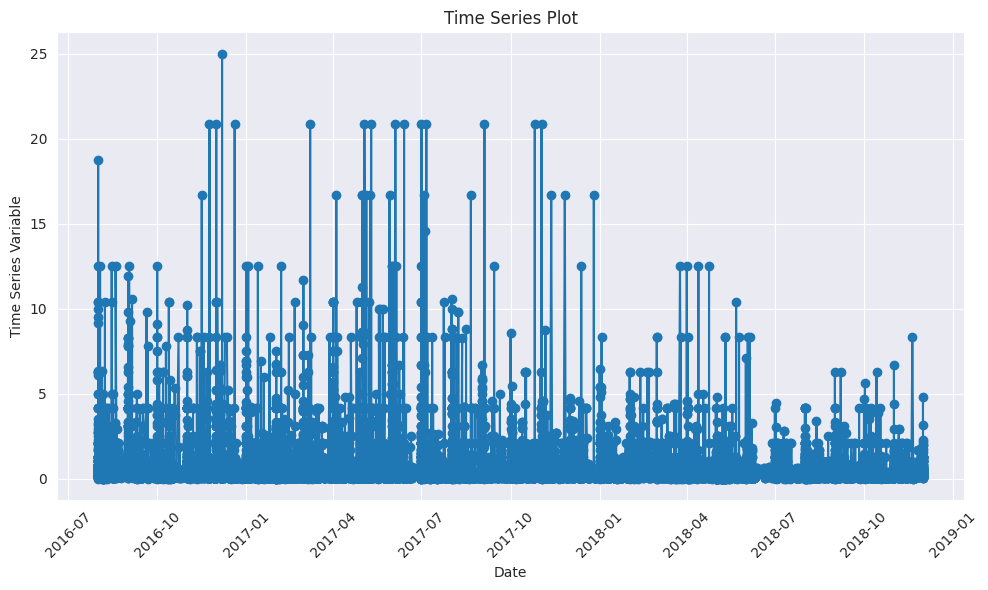

In [26]:
# Plot for "Daily" order
# Example DataFrame creation with datetime index
df_daily_plot = df.sort_index()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(df_daily_plot.index, df_daily_plot['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


## Decompose Time Series 

In [51]:
stacked_df = stacked_df.sort_index()

<Axes: xlabel='date', ylabel='order_qty'>

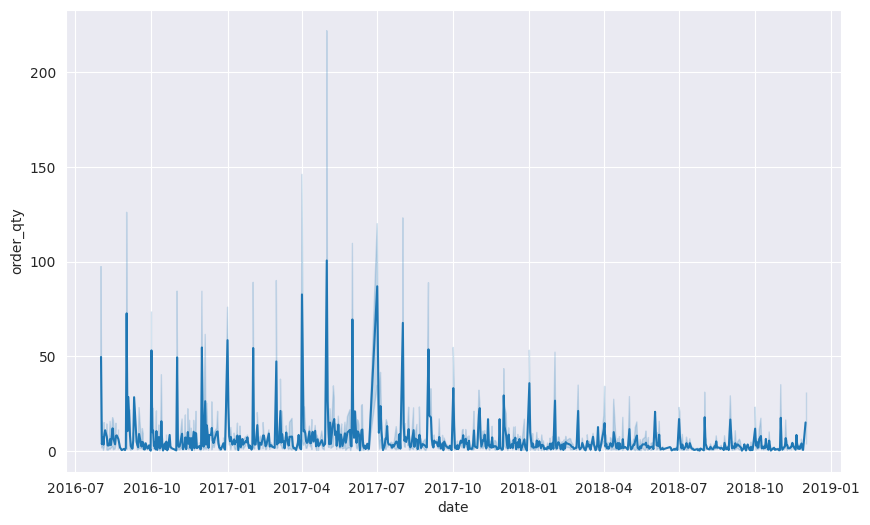

In [52]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="order_qty",legend = 'full' , data=stacked_df)

<Axes: xlabel='date', ylabel='order_qty'>

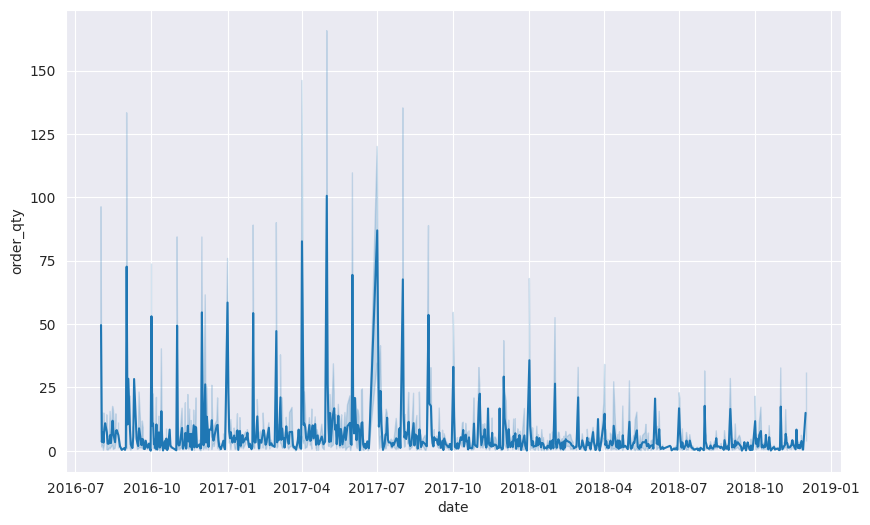

In [53]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="order_qty",legend = 'full' , data=stacked_df)

<Axes: xlabel='weekday', ylabel='order_qty'>

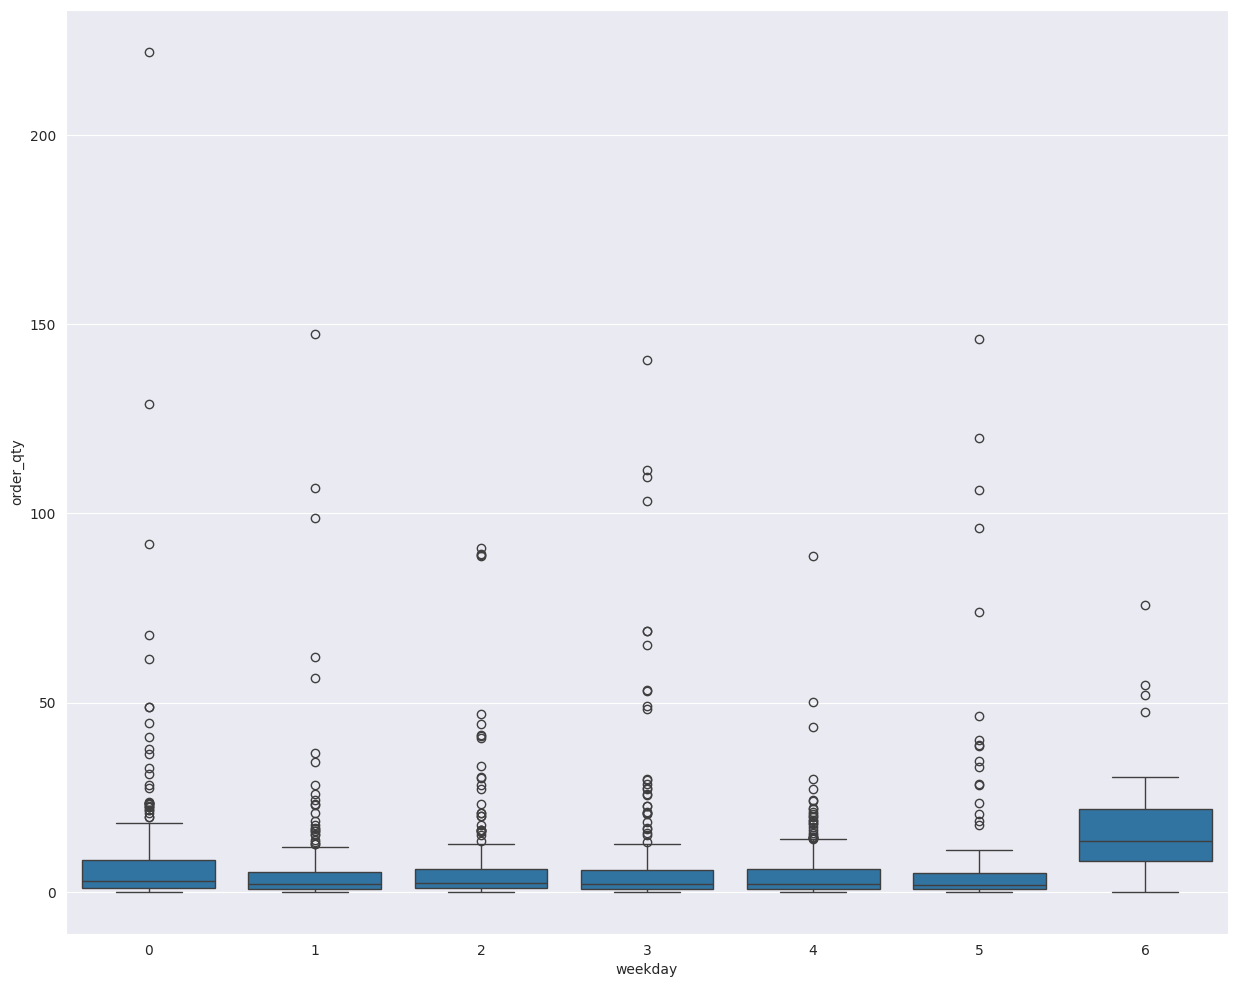

In [54]:
plt.figure(figsize=(15, 12))
sns.boxplot(x="weekday", y="order_qty", data=stacked_df)

In [93]:
autocorr = stacked_df['order_qty'].autocorr()
seasonality_period = round(1 / autocorr)

<Figure size 640x480 with 0 Axes>

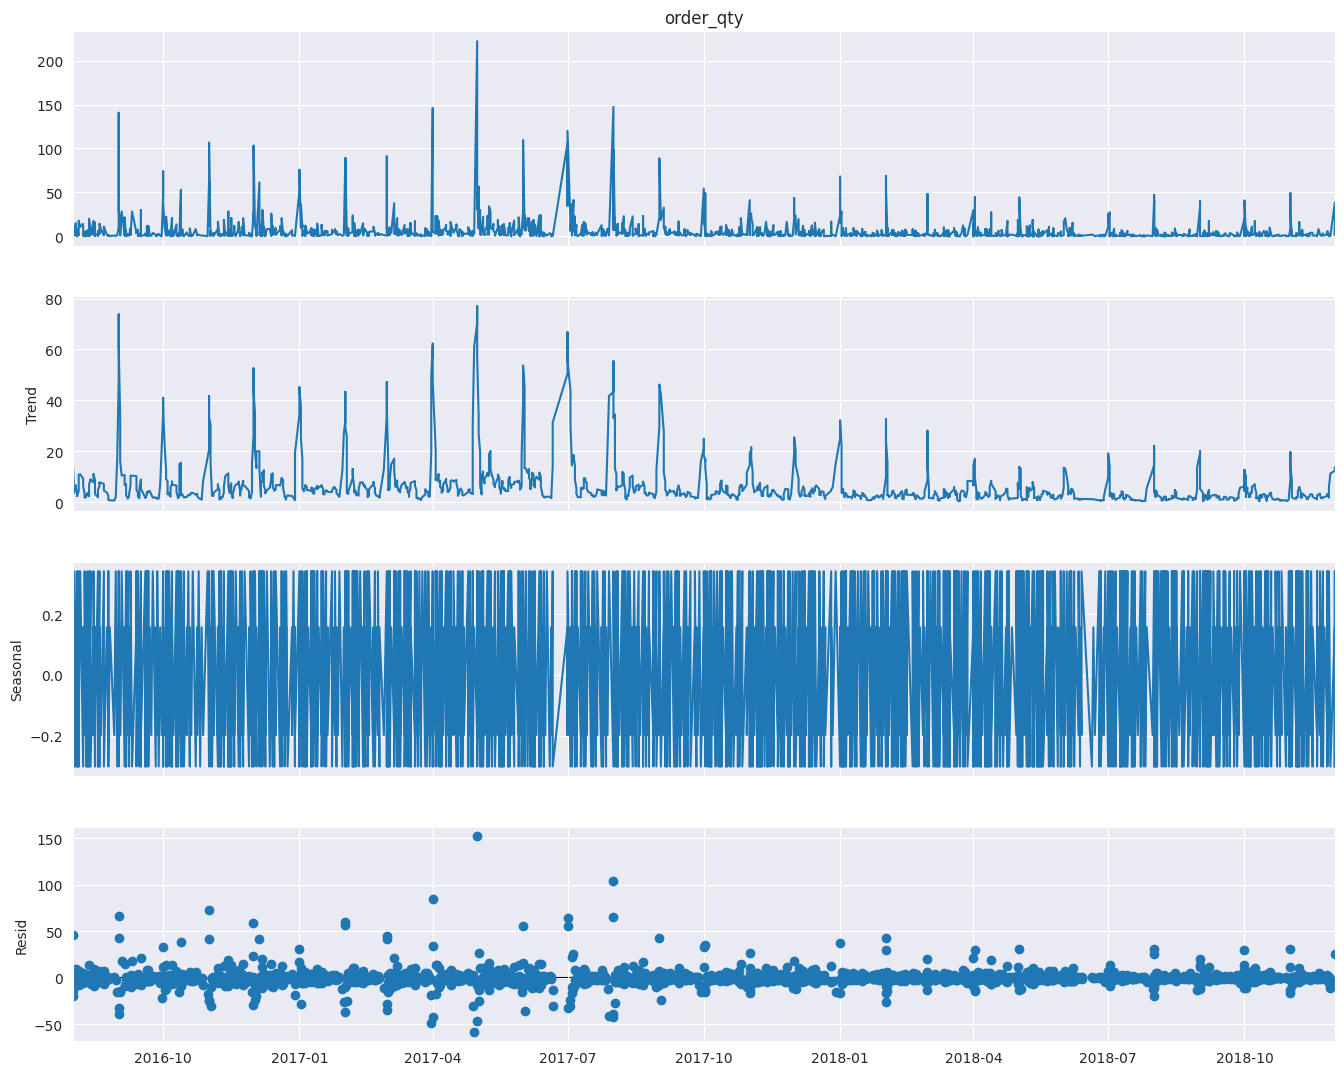

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(stacked_df['order_qty'], model='additive', period = seasonality_period)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## Stationarize the data

In [84]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 30 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

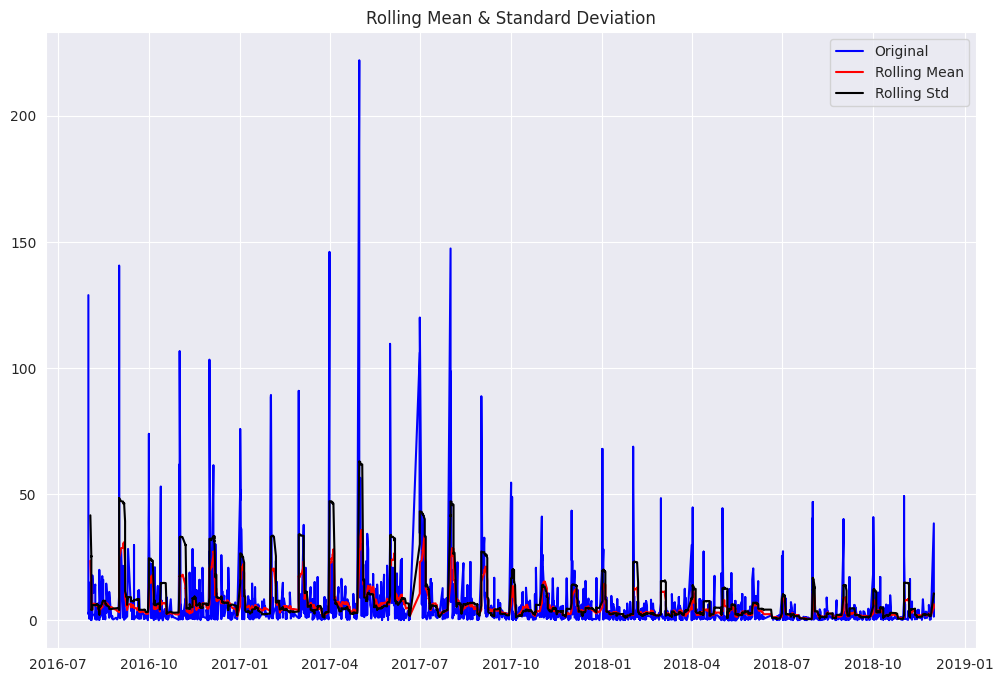

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -19.444394
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1763.000000
Critical Value (1%)              -3.434065
Critical Value (5%)              -2.863181
Critical Value (10%)             -2.567644
dtype: float64


In [85]:
test_stationarity(stacked_df['order_qty'])

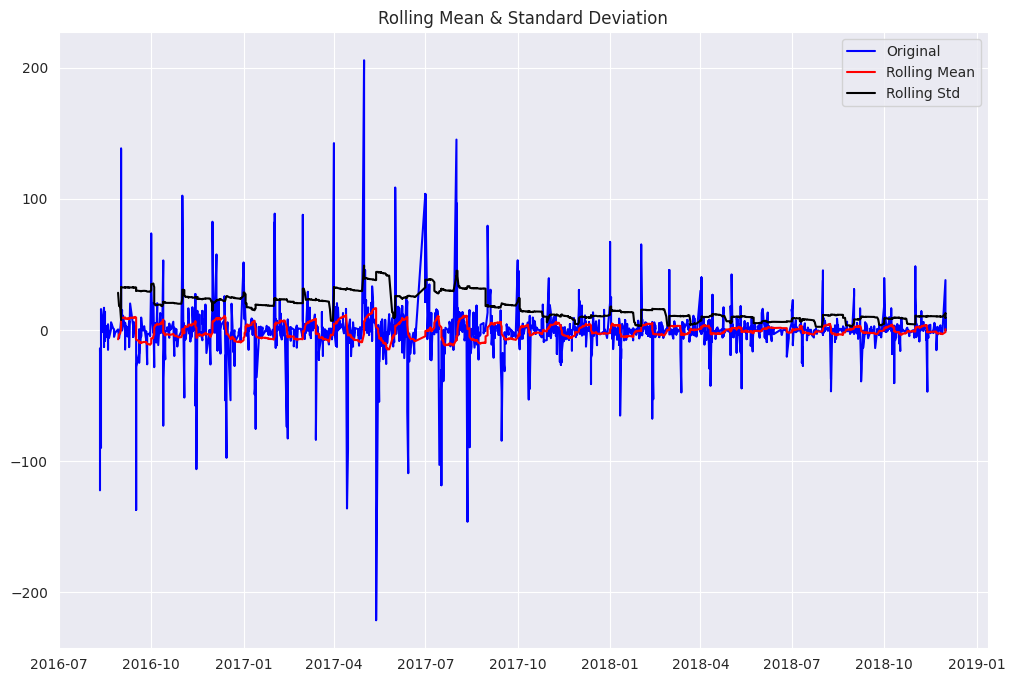

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.559814e+01
p-value                        1.843714e-28
#Lags Used                     3.000000e+01
Number of Observations Used    1.705000e+03
Critical Value (1%)           -3.434191e+00
Critical Value (5%)           -2.863237e+00
Critical Value (10%)          -2.567673e+00
dtype: float64


In [88]:
first_diff = stacked_df.order_qty - stacked_df.order_qty.shift(30)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 30)

## ACF & PACF

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

Summary
From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot we know we need to add AR terms.

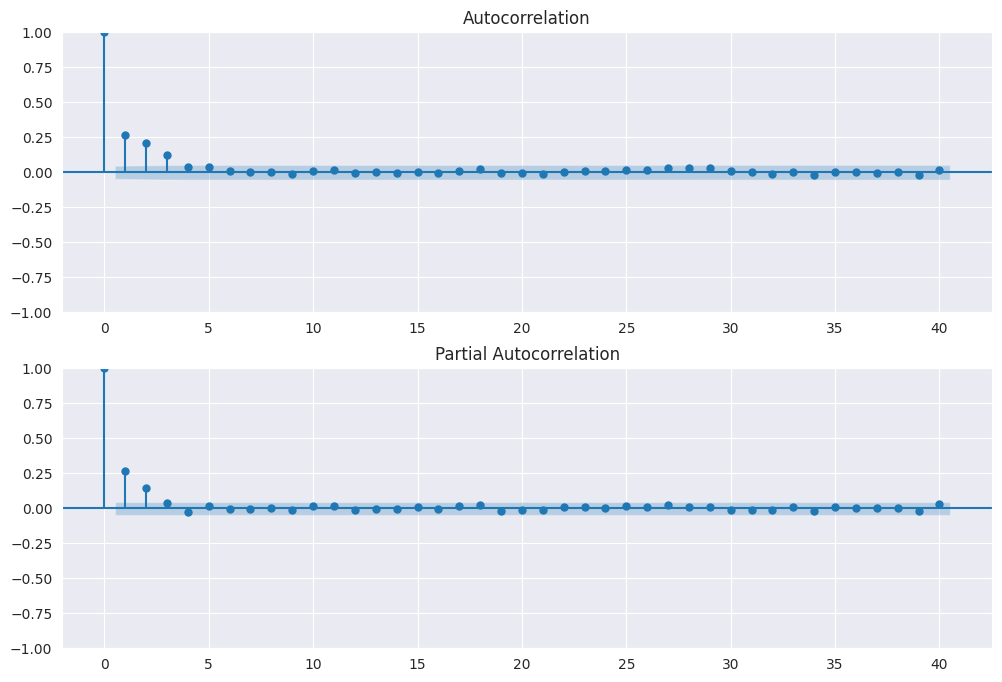

In [68]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stacked_df.order_qty, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stacked_df.order_qty, lags=40, ax=ax2)# , lags=40

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Because the autocorrelation of the differenced series is negative at lag 7, 14, 21 etc.. (every week), I should an SMA term to the model.

Build the model

How to determin p, d, q
It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use AR = 6

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [69]:
arima_mod6 = sm.tsa.ARIMA(stacked_df.order_qty, (0,1,0)).fit(disp=False)
print(arima_mod6.summary())

ValueError: endog and exog matrices are different sizes

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

<Figure size 640x480 with 0 Axes>

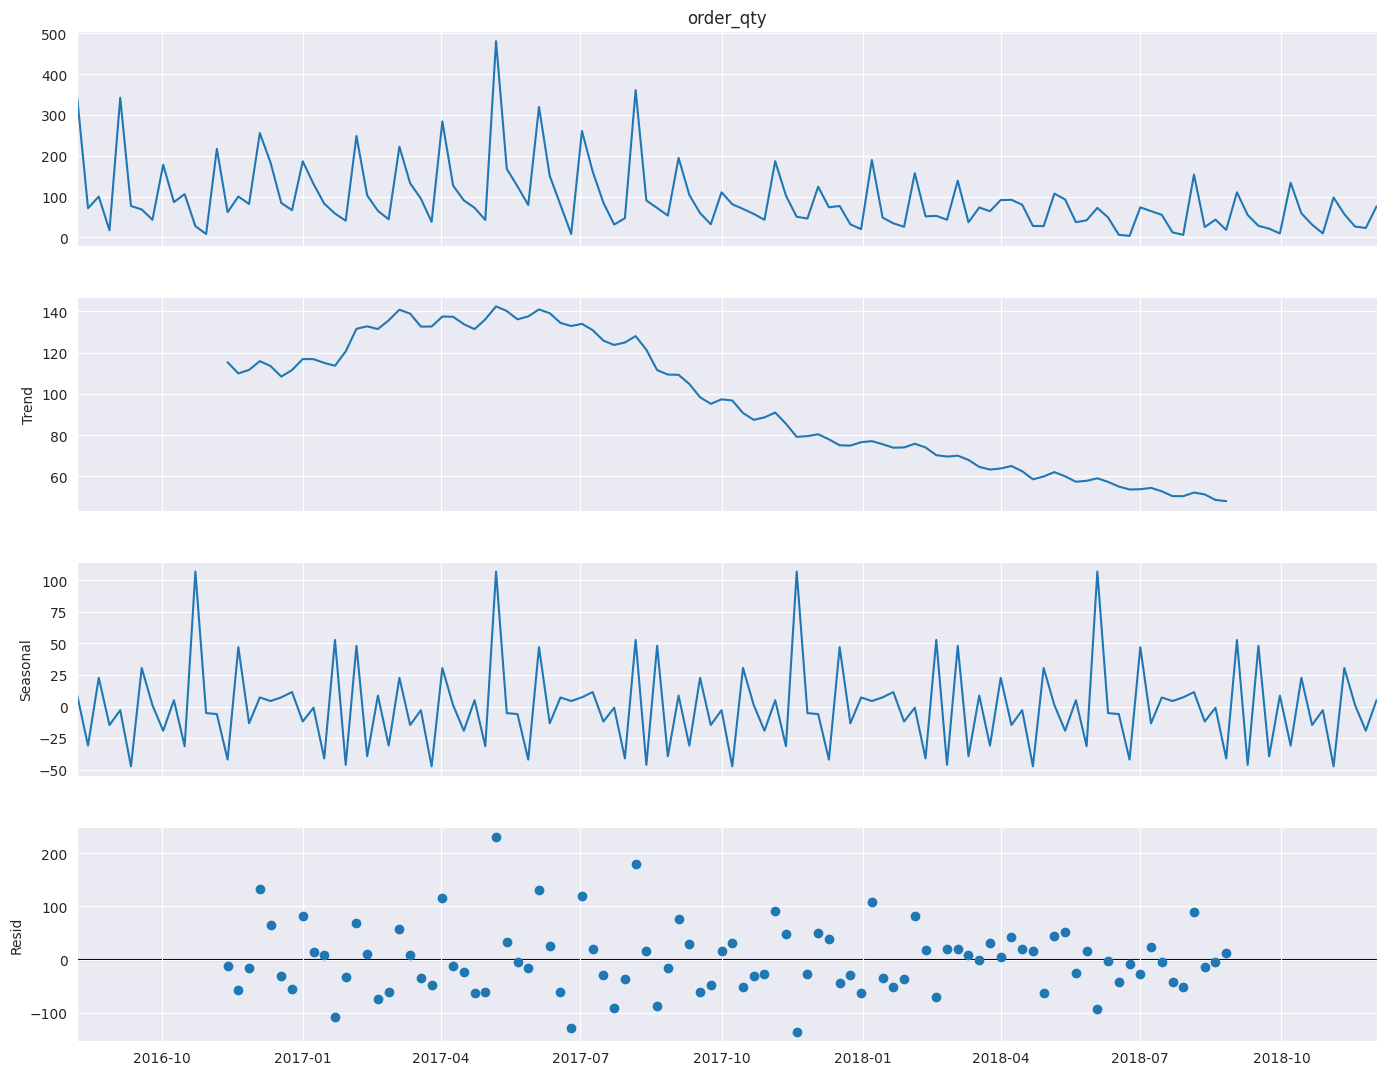

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(stacked_df_w['order_qty'], model='additive', period = 28)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## Stationarize the data

In [103]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 28, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 14 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

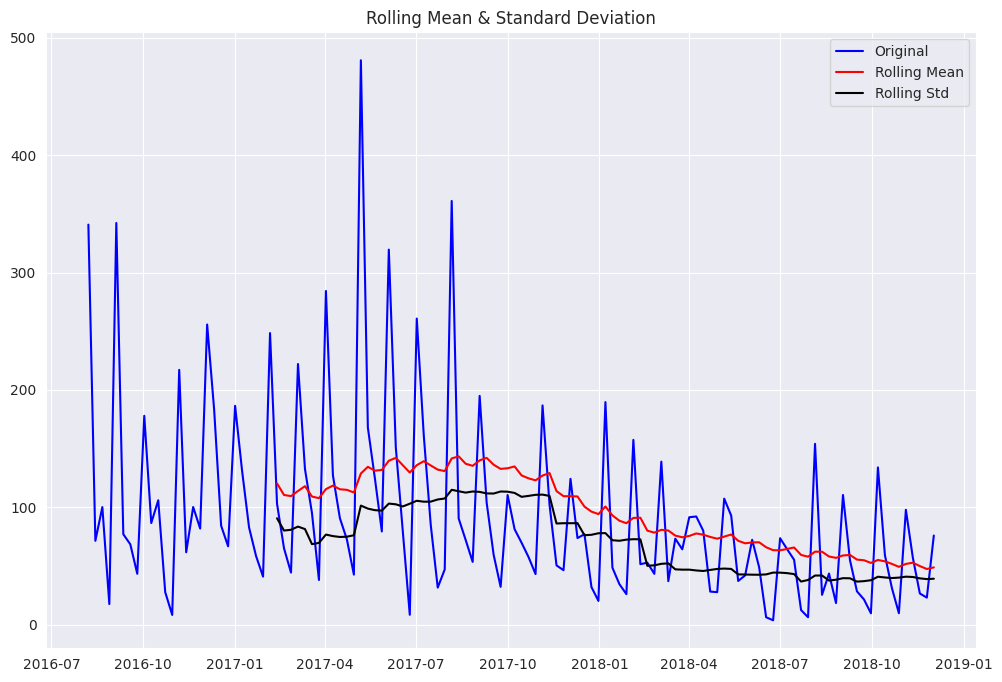

Results of Dickey-Fuller Test:
p-value = 0.9031. The series is likely non-stationary.
Test Statistic                  -0.440324
p-value                          0.903145
#Lags Used                      12.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


In [104]:
test_stationarity(stacked_df_w['order_qty'])

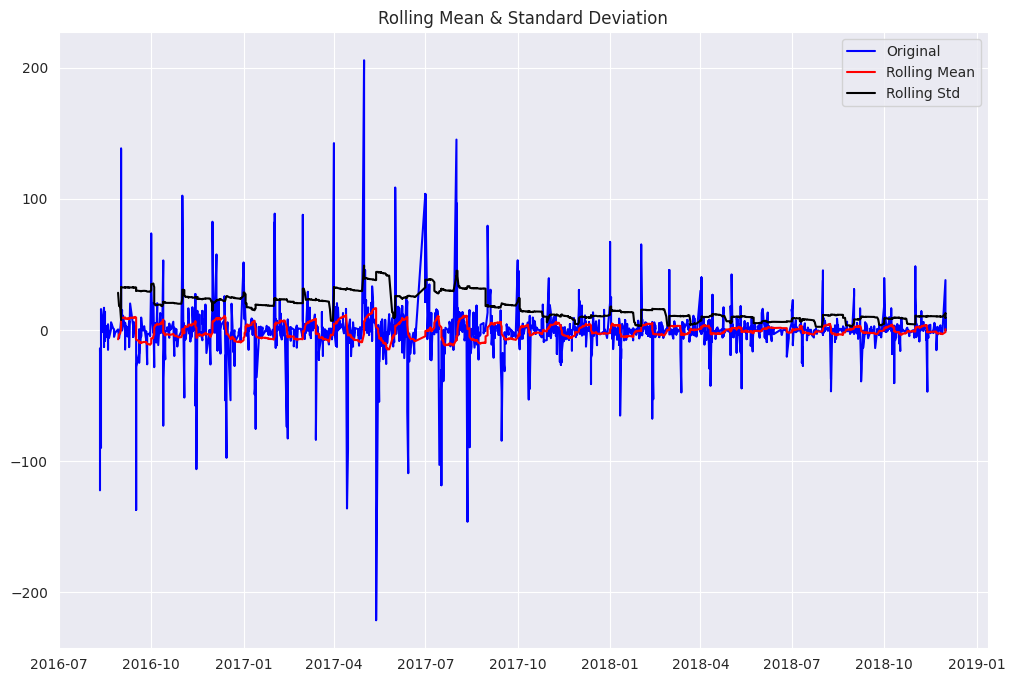

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.559814e+01
p-value                        1.843714e-28
#Lags Used                     3.000000e+01
Number of Observations Used    1.705000e+03
Critical Value (1%)           -3.434191e+00
Critical Value (5%)           -2.863237e+00
Critical Value (10%)          -2.567673e+00
dtype: float64


In [ ]:
first_diff = stacked_df.order_qty - stacked_df.order_qty.shift(30)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 30)

## ACF & PACF

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

Summary
From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot we know we need to add AR terms.

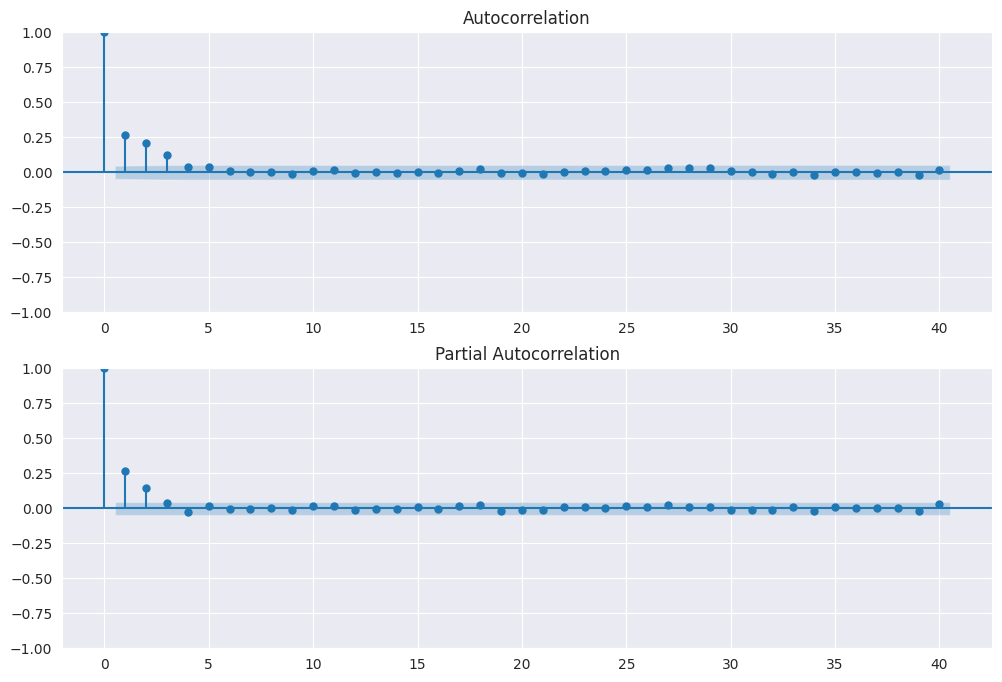

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stacked_df.order_qty, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stacked_df.order_qty, lags=40, ax=ax2)# , lags=40

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Because the autocorrelation of the differenced series is negative at lag 7, 14, 21 etc.. (every week), I should an SMA term to the model.

Build the model

How to determin p, d, q
It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use AR = 6

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [ ]:
arima_mod6 = sm.tsa.ARIMA(stacked_df.order_qty, (0,1,0)).fit(disp=False)
print(arima_mod6.summary())

ValueError: endog and exog matrices are different sizes

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [ ]:
df['product_id'].unique()

In [ ]:
# Split dataframe for each product_id
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}'] = df[df['product_id'] == product].sort_index()
    print(f'Total rows in df_{product} :', len(g[f'df_{product}']))

In [ ]:
# Plot for "Daily" order
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1.index, df_A1['order_qty'], label='Product A1')
plt.plot(df_B2.index, df_B2['order_qty'], label='Product B2')
plt.plot(df_C3.index, df_C3['order_qty'], label='Product C3')
plt.plot(df_D4.index, df_D4['order_qty'], label='Product D4')
plt.plot(df_E5.index, df_E5['order_qty'], label='Product E5')
plt.plot(df_F6.index, df_F6['order_qty'], label='Product F6')
plt.plot(df_G7.index, df_G7['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Daily')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

### df_A1

## Decompose Time Series 

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="order_qty",legend = 'full' , data=df_A1)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="order_qty",legend = 'full' , data=df_A1[:28])

In [ ]:
plt.figure(figsize=(15, 12))
sns.boxplot(x="weekday", y="order_qty", data=df_A1)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_A1['order_qty'], model='additive', period = 365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## Stationarize the data

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [ ]:
test_stationarity(df_A1['order_qty'])

In [ ]:
first_diff = df_A1.order_qty - df_A1.order_qty.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

## ACF & PACF

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

Summary
From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot we know we need to add AR terms.

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.order_qty, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.order_qty, lags=40, ax=ax2)# , lags=40

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Because the autocorrelation of the differenced series is negative at lag 7, 14, 21 etc.. (every week), I should an SMA term to the model.

Build the model

How to determin p, d, q
It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use AR = 6

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [ ]:
arima_mod6 = sm.tsa.ARIMA(df_A1.order_qty, (0,1,0)).fit(disp=False)
print(arima_mod6.summary())

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot for "Weekly" order
# Example DataFrame creation with datetime index
date_resample_w = df.resample('W').mean()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(date_resample_w.index, date_resample_w['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


In [ ]:
# Plot for "Monthly" order
# Example DataFrame creation with datetime index
date_resample_m = df.resample('M').mean()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(date_resample_m.index, date_resample_m['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


#### Check lineplot order quantity for each product

In [ ]:
df['product_id'].unique()

In [ ]:
# Split dataframe for each product_id
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}'] = df[df['product_id'] == product].sort_index()
    print(f'Total rows in df_{product} :', len(g[f'df_{product}']))

In [ ]:
# Plot for "Daily" order
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1.index, df_A1['order_qty'], label='Product A1')
plt.plot(df_B2.index, df_B2['order_qty'], label='Product B2')
plt.plot(df_C3.index, df_C3['order_qty'], label='Product C3')
plt.plot(df_D4.index, df_D4['order_qty'], label='Product D4')
plt.plot(df_E5.index, df_E5['order_qty'], label='Product E5')
plt.plot(df_F6.index, df_F6['order_qty'], label='Product F6')
plt.plot(df_G7.index, df_G7['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Daily')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [ ]:
df_A1_w

In [ ]:
# Plot for "Mothly" order
for product in df['product_id'].unique():
    g[f'df_{product}_m'] = g[f'df_{product}'].resample('M').mean()

# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_m.index, df_A1_m['order_qty'], label='Product A1')
plt.plot(df_B2_m.index, df_B2_m['order_qty'], label='Product B2')
plt.plot(df_C3_m.index, df_C3_m['order_qty'], label='Product C3')
plt.plot(df_D4_m.index, df_D4_m['order_qty'], label='Product D4')
plt.plot(df_E5_m.index, df_E5_m['order_qty'], label='Product E5')
plt.plot(df_F6_m.index, df_F6_m['order_qty'], label='Product F6')
plt.plot(df_G7_m.index, df_G7_m['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Monthly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

#### Check lineplot order quantity for each store

In [ ]:
df['store'].unique()

In [ ]:
# Split dataframe for each store
g = globals()

for store in df['store'].unique():
    g[f'df_{store}'] = df[df['store'] == store].sort_index()
    print(f'Total rows in df_{store} :', len(g[f'df_{store}']))